In [1]:
import os
import sys

# Get the directory of the current file
current_dir = os.path.dirname(os.path.realpath('__file__'))

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the system path
sys.path.insert(0, parent_dir)
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
import pyidi                    # Python HSC data analysis library
import pickle as pk
from pixel_setter2 import PixelSetter#, play_video, detect_peaks
from pixel_setter import play_video
from scipy.ndimage import uniform_filter
import importlib
from EMA_functions import *
from Feature_selecter import *
import matplotlib.animation as animation
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
df = pd.read_csv('H:/My Drive/PHD/HSC/file_descriptions_wlocs.csv')
file_name_basis = 'Full_web_ecc2_new2_Floc18_v'
v_vec = [5, 7]
file_name_vec = [file_name_basis + str(x) for x in v_vec]
file_name_vec_video = [x + '_S01.cihx' for x in file_name_vec]
df_filtered = df[df['filename'].isin(file_name_vec_video)]

df_filtered

,filename,path,ecc,loc,mass,taut/loose,impact/pluck,version,n_frames,fps,Oversatured pixels,Undersatured pixels,prey_ij,spider_ij
123,Full_web_ecc2_new2_Floc18_v5_S01.cihx,H:\My Drive\PHD\HSC\ecc2\web1\Full_web_ecc2_ne...,2,18,True,Loose,Impact,5,8000,8000.0,727,18127,"(356, 234)","(553, 229)"
125,Full_web_ecc2_new2_Floc18_v7_S01.cihx,H:\My Drive\PHD\HSC\ecc2\web1\Full_web_ecc2_ne...,2,18,True,Loose,Impact,7,8000,8000.0,210,18900,"(357, 235)","(553, 229)"


In [3]:
EMA_structure = EMA_Structure(file_name_vec[0])
video = EMA_structure.open_video()
# video = pyidi.pyIDI("D:/thijsmas/HSC/ecc2/web1/rev2/Full_web_ecc2_new2_Floc18_v5_S01/" + file_name_vec[0]+'_S01.cihx')
# video.set_method('lk_1D')

H:/My Drive/PHD/HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v5_S01\Full_web_ecc2_new2_Floc18_v5_S01.cihx


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 8000, Original total frame: 87371)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


In [4]:
%matplotlib qt
sequential_image_n = 0
still_image = video.mraw[sequential_image_n]

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False)

## Find eigenvalue picture

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


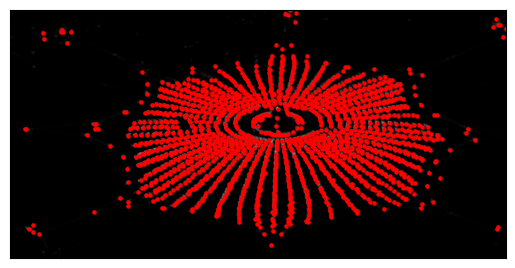

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [20]:
%matplotlib inline
roi_size = (5,5)
reference_image = (0, 150)
n_tracking_points = 1800
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)
feature_selecter = FeatureSelecter(still_image)
feature_selecter.set_filter_method('eig0', roi_size)
# feature_selecter.plot_image()
score_full = feature_selecter.apply_filter(downsample=1)
maxima2d = feature_selecter.pick_max_filter(score_image = None, min_distance = roi_size[0], absolute_treshold = None, threshold_percentage = 20, top_n_points = n_tracking_points)
# maxima = feature_selecter.pick_ANMS(n_points = n_tracking_points, c_robust = 0.3)
feature_selecter.plot_score_image(maxima=True)
# eig_img = pix_set.find_eigenvalue_image(mean_image, roi_size[0], method = 'on_gradient')
# fig, ax = plt.subplots()
# plt.imshow(eig_img, cmap='gray')

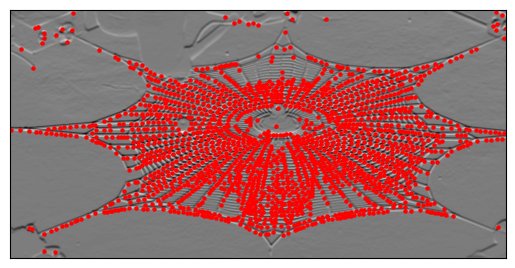

In [21]:
filtered_image = uniform_filter(mean_image, size=roi_size[0])
Gi, Gj = np.gradient(filtered_image)
# maxima1d = feature_selecter.pick_max_filter(score_image = Gi, min_distance = roi_size[0], absolute_treshold = None, threshold_percentage = 90, top_n_points = None)
maxima1d = feature_selecter.pick_max_filter(score_image = Gi, min_distance = roi_size[0]+3, absolute_treshold = None, threshold_percentage = 20, top_n_points = n_tracking_points)
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(Gi, cmap='gray')
ax.scatter(maxima1d[:, 1], maxima1d[:, 0], s=5, c='r')
plt.show()

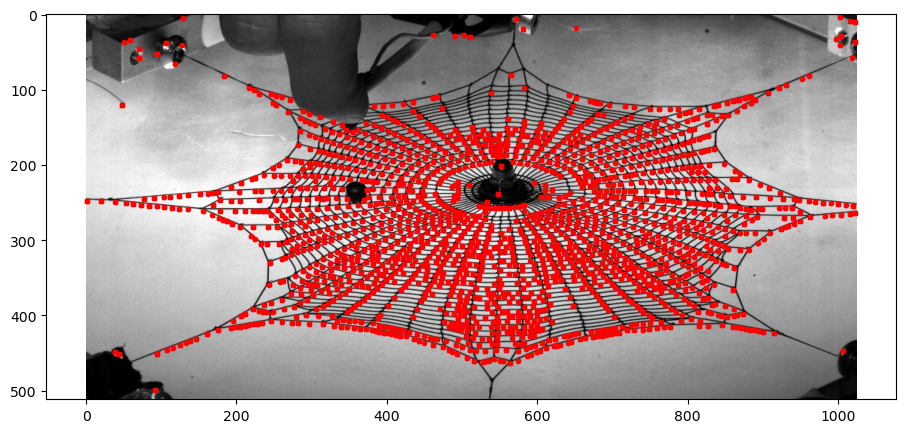

In [11]:
video.set_method('lk')
video.method.configure(roi_size = roi_size, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
video.set_points(maxima1d)
displacements2D_1Dpoints = video.get_displacements()
video.set_points(maxima2d)
displacements2D_2Dpoints = video.get_displacements()

In [ ]:
%matplotlib qt
td = video.displacements +  maxima1d.reshape(len(maxima1d),1,2)
ani = play_video(video, range(200, video.N-1), interval=10, points=td[:, 1:, :])

In [ ]:
%matplotlib inline
point = 4
window_size = 3 * 2
fig, ax = plt.subplots()
ax.imshow(mean_image, cmap='gray')
ax.scatter(maxima1d[:, 1], maxima1d[:, 0], s=10, c='r', marker='x')
ax.set_xlim(maxima1d[point, 1]-window_size, maxima1d[point, 1]+window_size)
ax.set_ylim(maxima1d[point, 0]-window_size, maxima1d[point, 0]+window_size)
ax.plot(td[point, :, 1], td[point, :, 0], 'r:')


In [ ]:
video.set_method('lk_1D')
d = (0,1) #(1,0) #
video.method.configure(roi_size = roi_size, d = d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
video.set_points(maxima1d)
video.show_points()
displacements1D_1Dpoints = video.get_displacements()
video.set_points(maxima2d)
displacements1D_2Dpoints = video.get_displacements()

In [ ]:
%matplotlib qt
td2     = video.displacements +  maxima1d.reshape(len(maxima1d),1,2)
ani = play_video(video, range(300, video.N-1), interval=30, points=td2[:, 1:, :], axis=([0, video.info['Image Width']],[video.info['Image Height'], 0]))

In [ ]:
%matplotlib inline
point = 8#4
window_size = 2 * 2
fig, ax = plt.subplots()
ax.imshow(mean_image, cmap='gray')
ax.set_xlim(maxima1d[point, 1]-window_size, maxima1d[point, 1]+window_size)
ax.set_ylim(maxima1d[point, 0]-window_size, maxima1d[point, 0]+window_size)
ax.plot(td2[point, :, 1], td2[point, :, 0], 'r-', label='1D')
ax.plot(td[point, :, 1], td[point, :, 0], 'b-', label='2D')
ax.plot(maxima1d[:, 1], maxima1d[:, 0], 'rx')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
fig.savefig(os.path.join(EMA_structure.root_simulations,'1d-2d-motion',file_name_vec[0]+"_motion_overlay.png"), dpi=300, bbox_inches='tight')



In [ ]:
video.info

In [ ]:
%matplotlib inline
t_vec = np.arange(0, len(displacements1D[0, :, 0]), 1) /video.info['Record Rate(fps)']
point = 8
maximum = np.max(np.linalg.norm(displacements2D[point, :], axis=1))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t_vec, displacements1D[point, :, 0]/maximum, 'r', label='y-displacements (1D)')
ax.plot(t_vec, displacements2D[point, :, 0]/maximum, 'b--', label='y-displacements (2D)')
# ax.plot(t_vec, np.linalg.norm(displacements2D[point, :], axis=1)/maximum, label='2d-norm')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (px)')
ax.legend()
fig.savefig(os.path.join(EMA_structure.root_simulations,'1d-2d-motion',file_name_vec[0]+"_signals.png"), dpi=300, bbox_inches='tight')